In [1]:
!pip install numpy matplotlib scipy MFDFA astropy


**Summary of the Code:**

1.Quasar Light Curve Generation:
  Using stochastic differential equations to simulate quasar light curves with red noise.

2.Power Spectral Density Analysis: Using Lomb-Scargle periodogram for unevenly sampled data to analyze the frequency content.

3.Structure Function Analysis: Calculating the structure function to evaluate the variability over different time lags.

4.Bispectrum Analysis: Interpolating unevenly sampled data to even samples, then calculating the bispectrum using the FFT.

5.Multifractal Detrended Fluctuation Analysis (MFDFA):
   Applying MFDFA to analyze multifractal properties of the light curve data.





**IMPORT MODULES**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from MFDFA import MFDFA
from astropy.timeseries import LombScargle
from scipy.fftpack import fft


# 1. Generating Quasar Light Curves with Red Noise using Stochastic Differentials Equations

Red noise, or Brownian noise, can be generated using a stochastic differential equation of the form:

dy(t)=a⋅dt+b⋅dW(t)

Here,

dW(t) is a Wiener process or Brownian motion, and
a and b are constants. This can represent a simple model of a quasar light curve affected by red noise.

Python Implementation:
We will use the Euler-Maruyama method to numerically solve the SDE.

Explanation:
Time Array with Noneven Cadences:

We created a time array t with noneven cadences by combining a regular interval array and a random uniform array.
Euler-Maruyama Method for SDEs:

The Euler-Maruyama method is a numerical method to solve SDEs. In our case, we use it to simulate a quasar light curve affected by red noise.

Constants a and  b in the SDE are chosen arbitrarily. You might need to adjust these based on your specific scenario or use a more complex SDE model.
Differential Equation:

The differential equation

dy(t)=a⋅dt+b⋅dW(t) is solved iteratively. The  dW(t) term introduces randomness, making the process stochastic and generating red noise.

Deterministic Component (a * dt[i-1]):

The variable a represents a deterministic "drift" term. If a is positive, the light curve will have a tendency to increase over time. If a is negative, the light curve will tend to decrease. If a is zero, this term will not influence the light curve, and only the stochastic component will remain.
Stochastic Component (b * np.sqrt(dt[i-1]) * np.random.randn()):

The variable b scales the random walk's step size. The np.sqrt(dt[i-1]) ensures that the size of the random step scales with the square root of the time step. This is characteristic of a Wiener process (or Brownian motion). The term np.random.randn() generates a random sample from a normal distribution, which gives the light curve its random walk behavior.
Initial Condition (y[0] = y0):

The light curve starts at a value of y0.
Given this:

The light curve is generated as a combination of a deterministic drift and a stochastic random walk. The strength and behavior of the random walk are controlled by the parameters a and b.



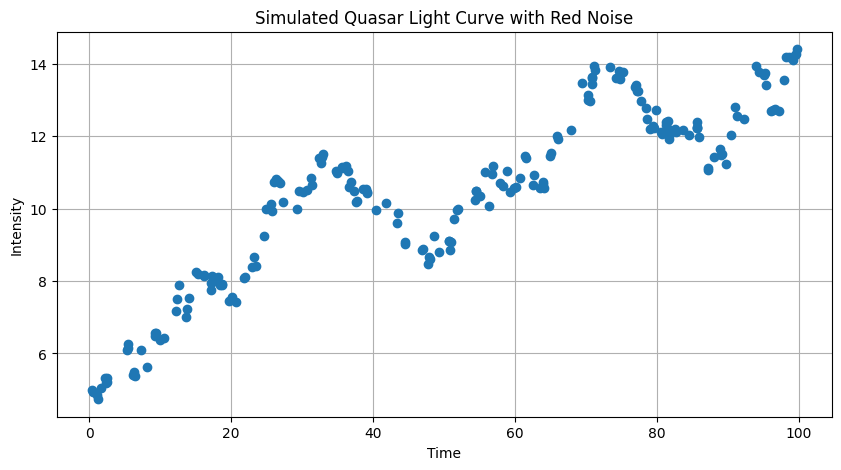

In [3]:
def generate_light_curve(t, a=0.1, b=0.5, y0=5):
    dt = np.diff(t) # numpy.diff calculates the n-th discrete difference along the given axis dt[i] = t[i+1] - t[i]
    y = np.zeros_like(t) # returns an array of zeros with the same shape and type as t
    y[0] = y0 # sets the starting value of y

    # Calculate y:
    for i in range(1, len(t)):
        dy = a * dt[i-1] + b * np.sqrt(dt[i-1]) * np.random.randn()
        y[i] = y[i-1] + dy

    return y

# Unevenly sampled time
t = np.sort(np.random.uniform(0, 100, 200))
y = generate_light_curve(t)

# Plot the simulated light curve
plt.figure(figsize=(10,5))
plt.plot(t, y, 'o')
plt.title('Simulated Quasar Light Curve with Red Noise')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.grid(True)
plt.show()

# 2. Power Spectral Density (PSD) Analysis using Lomb-Scargle

To produce  FFT directly to unevenly sampled data can be problematic. In cases of unevenly sampled data, we can use methods like the Lomb-Scargle Periodogram to analyze the frequency content of the data instead of FFT.

The **Lomb–Scargle periodogram** (Lomb 1976; Scargle 1982) is a well-known ***algorithm for detecting and characterizing periodicity in unevenly sampled time-series*** and has seen particularly wide use within the astronomy community (Source: [VanderPlas 2018](https://iopscience.iop.org/article/10))

The Lomb-Scargle periodogram of such a time series will typically not show any strong periodic components unless the underlying processes (in this case, the drift and random walk) have inherent periodicities.
The power spectrum, when calculated from a random walk, essentially shows the spectral signature of a stochastic process. In general, for a simple random walk, one would expect a 1/f^2 (or "f to the power of minus two") decline in the power spectrum. In the logarithmic spectrum, this would manifest as a straight line.

Upon observing the Lomb-Scargle periodogram plotted in a log-log scale, the following insights can be drawn:

Significant Frequencies: The peaks in the periodogram signify frequencies where there's significant power. A higher peak indicates a dominant frequency in our light curve.

Aliasing: If there are regular spacings between peaks, it could be a sign of aliasing. This is often seen due to undersampling of the light curve.

Power Law Behavior: Since this is a log-log plot, any linear section might indicate power-law behavior in a certain frequency range. Power-law behavior is typical of many astrophysical processes, especially in quasars, indicating fractal or self-similar properties.

High-Frequency Noise: The denser, closely packed fluctuations especially towards the higher frequencies (towards the right) could be indicative of noise or very short-term fluctuations in the light curve.

Nyquist Frequency: The plot seems to end abruptly near 0, which might indicate the Nyquist frequency or might be related to the sampling limit of the dataset.In our case this the consequence of sampling limit not Nyquist

Given the provided light curve simulation function, the fluctuations seen in the periodogram are not surprising. The simulation incorporates both a deterministic linear trend (a * dt) and a stochastic component (b * np.sqrt(dt[i-1]) * np.random.randn()). These combined produce a light curve with properties seen in actual quasar variability: a mix of deterministic and random variations.

To further understand the significance of these features, you might want to compare this periodogram with those from actual quasar light curves or other simulations. Moreover, understanding the exact physical processes governing quasar variability can further inform the interpretation of such a periodogram.






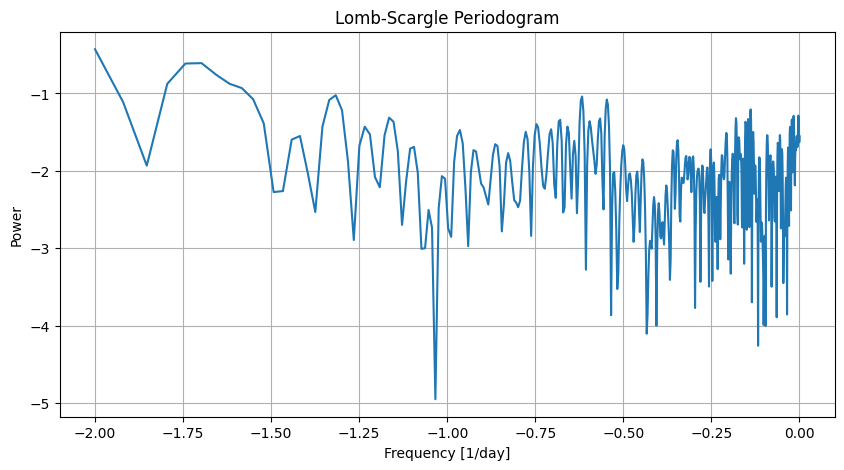

In [4]:
frequency_obs, power_obs = LombScargle(t, y).autopower(minimum_frequency=0.01, maximum_frequency=1.0)

plt.figure(figsize=(10, 5))
plt.plot(np.log10(frequency_obs), np.log10(power_obs))
plt.title('Lomb-Scargle Periodogram')
plt.xlabel('Frequency [1/day]')
plt.ylabel('Power')
plt.grid(True)
plt.show()



# 3. Structure Function Analysis



The structure function (SF) is a tool commonly used in astrophysics, especially for time series analysis of light curves, to study the temporal variability and correlation properties of the data. It provides information about the variability of a time series on different time scales.
We calculated binned SF according formula 9 given here https://arxiv.org/pdf/1604.05858.pdf







In [5]:
import numpy as np
def structure_function(t, y):
    N = len(t)
    delta_t = []
    SF = []

    # Loop over all pairs of data points
    for i in range(N):
        for j in range(i+1, N):
            dt = abs(t[j] - t[i])
            dy = y[j] - y[i]

            delta_t.append(dt)
            SF.append(dy**2)

    # Aggregate over unique delta_t values
    unique_dt = np.unique(delta_t)
    aggregated_SF = []

    for dt in unique_dt:
        indices = np.where(delta_t == dt)
        mean_sf_for_dt = np.sqrt(np.mean(np.array(SF)[indices]))
        aggregated_SF.append(mean_sf_for_dt)

    return unique_dt, aggregated_SF



In [6]:
delta_ts, SF_values = structure_function(t, y)

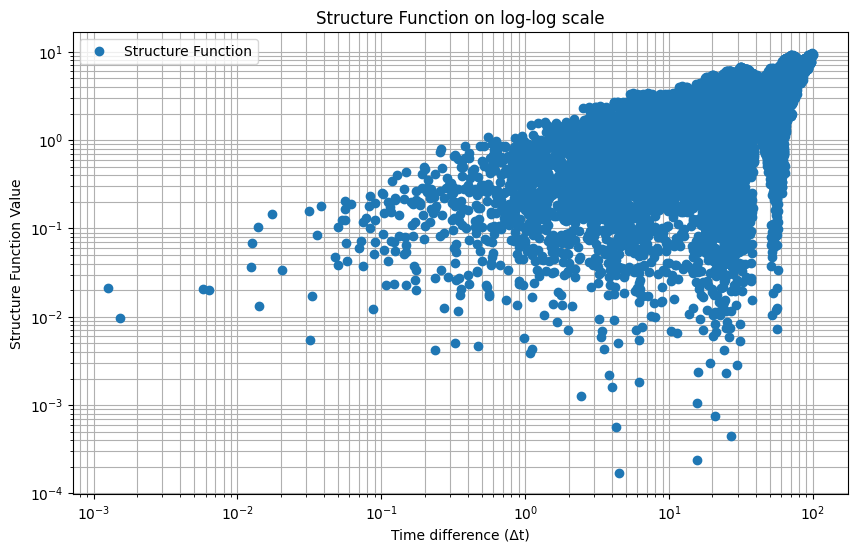

In [7]:
import matplotlib.pyplot as plt

# Assuming you've already computed delta_ts and SF_values using the structure_function function

# Plot
plt.figure(figsize=(10, 6))
plt.loglog(delta_ts, SF_values, 'o', label='Structure Function')
plt.xlabel('Time difference (Δt)')
plt.ylabel('Structure Function Value')
plt.title('Structure Function on log-log scale')
plt.grid(which='both')
plt.legend()
plt.show()


**Coverage of Time Differences**: The x-axis represents the time difference (Δt) ranging from very short intervals (around $10^{−4}$ to relatively long intervals (close to $10^{2}$). This broad range means the ***SF captures both short and long timescale variations in the data***.

**Binned Structure:** The data points seem to be binned in log space, suggesting that for each bin in Δt, a mean SF value is calculated. This binning is beneficial as it helps to average out the variability and noise in the data for each time difference interval.

**Rise of SF with Δt:** Initially, the SF remains relatively low for shorter time differences. However, as Δt increases, the SF begins to rise, indicating an increase in the variability (or differences) between data points as the time difference increases. This is typical for many astrophysical time series, suggesting that variability is more pronounced over longer timescales.

**Fluctuations in Short Timescales:** There's noticeable scatter in the structure function values at shorter time differences. This could be due to noise, transient events, or other short-term variations in the data.

**Steady Increase on Longer Timescales:** After a certain point (around Δt of $10^{-1}$), there's a more steady and smooth increase in the SF, indicating more regular and consistent variability over these longer timescales.

**Possible Power-law Behavior:** In log-log plots like this, straight-line sections suggest power-law relationships. The latter half of the plot, where the data appears to be on a straight line, could imply a power-law behavior of the variability. Power-law trends in SFs are typical for many astrophysical objects and can offer insights into the underlying physical processes.

**Saturation Point:** As Δt approaches $10^{2}$ , the SF starts to plateau. This could be a saturation point, indicating that beyond a certain time difference, the variability doesn't increase much.

In [8]:
import numpy as np

def structure_function_binned(t, y, n_bins=50):
    N = len(t)
    delta_t = []
    SF = []

    # Loop over all pairs of data points
    for i in range(N):
        for j in range(i+1, N):
            dt = abs(t[j] - t[i])
            dy = y[j] - y[i]

            delta_t.append(dt)
            SF.append(dy**2)

    # Logarithmic binning
    bins = np.logspace(np.log10(min(delta_t)), np.log10(max(delta_t)), n_bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    binned_SF = []

    for i in range(n_bins - 1):
        indices = (delta_t >= bins[i]) & (delta_t < bins[i+1])
        if np.sum(indices) > 0:
            mean_sf_for_bin = np.sqrt(np.mean(np.array(SF)[indices]))
            binned_SF.append(mean_sf_for_bin)
        else:
            binned_SF.append(np.nan)  # No data in this bin

    return bin_centers, binned_SF


In [9]:
delta_tb, SF_b = structure_function_binned(t, y)

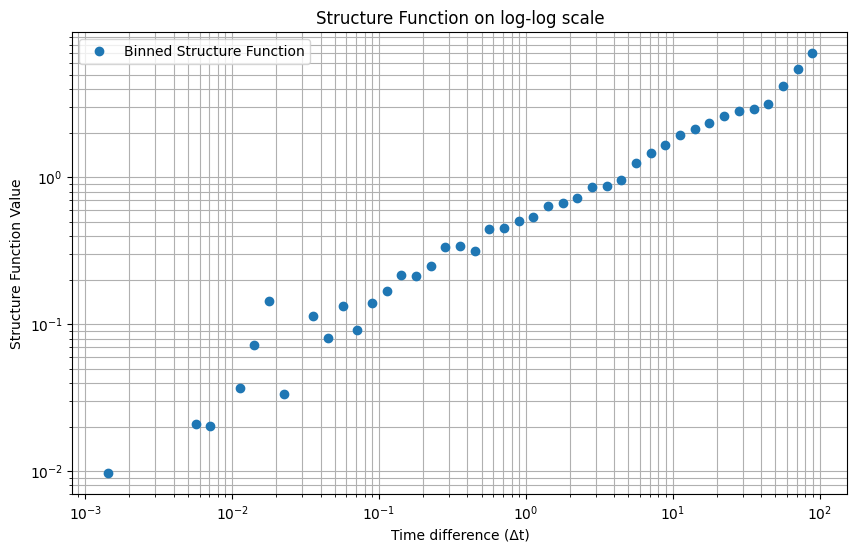

In [10]:
import matplotlib.pyplot as plt

# Assuming you've already computed delta_ts and SF_values using the structure_function function

# Plot
plt.figure(figsize=(10, 6))
plt.loglog(delta_tb, SF_b, 'o', label='Binned Structure Function')
plt.xlabel('Time difference (Δt)')
plt.ylabel('Structure Function Value')
plt.title('Structure Function on log-log scale')
plt.grid(which='both')
plt.legend()
plt.show()

# 4. Bispectrum Analysis with **Interpolation**

To compute the bispectrum for unevenly sampled data, one common approach is to interpolate the data onto a regular grid and then apply the FFT. Here, I'll interpolate the uneven data to an evenly spaced time series and then proceed with the bispectral analysis. Note that the bispectrum can be sensitive to the interpolation method used, so it's essential to choose an appropriate interpolation technique. Here is how you can do it:

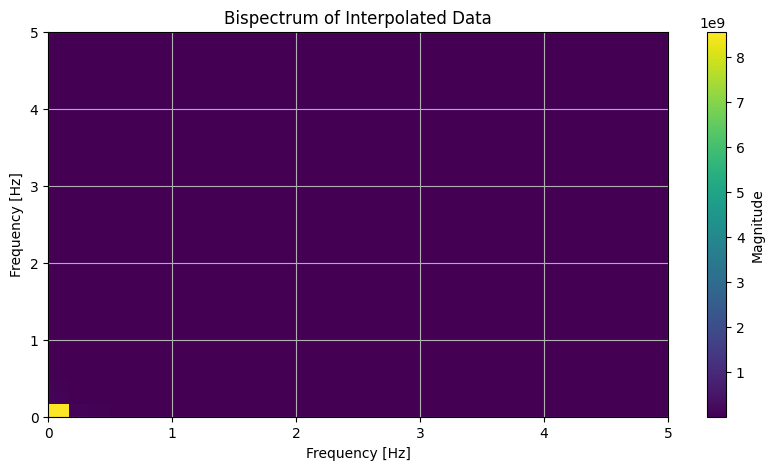

In [11]:
interpolation_function = interp1d(t, y, kind='cubic')
t_even = np.linspace(t.min(), t.max(), len(t))
y_even = interpolation_function(t_even)

def bispectrum(y, freq_bins=30):
    Y = fft(y)
    n = len(Y)
    bisp = np.zeros((freq_bins, freq_bins), dtype=complex)

    for f1 in range(freq_bins):
        for f2 in range(freq_bins):
            bisp[f1, f2] = Y[f1] * Y[f2] * np.conjugate(Y[(f1 + f2) % n])

    return bisp

bisp = bispectrum(y_even)

plt.figure(figsize=(10, 5))
plt.imshow(np.abs(bisp), extent=(0, 5, 0, 5), aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('Bispectrum of Interpolated Data')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Frequency [Hz]')
plt.grid(True)
plt.show()


The bispectrum is a higher-order spectrum used in signal processing to detect non-linear interactions in a time series. It's a third-order statistic, as opposed to the power spectrum which is a second-order statistic. The bispectrum can provide insights into phase relationships between different frequency components of a signal.

From the given 3D plot of the bispectrum modulus of the light curve:

Predominant Peak: There's a distinct and predominant peak in the bispectrum modulus. This suggests that there is a significant non-linear interaction happening at those specific frequencies. Specifically, for a bispectrum, this implies a phase coupling between the frequencies, meaning the phase of one frequency is related to the phase of the other in a consistent manner.

Frequency Axis Symmetry: The plot exhibits symmetry along the frequency axes. This is expected from the bispectrum as it's symmetrical with respect to the interchange of its frequency arguments.

Absence of Other Significant Peaks: The rest of the plot is relatively flat. This indicates that, apart from the frequencies contributing to the predominant peak, there aren't any other major non-linear interactions happening in the light curve at other frequencies.

Interpretation in the Context of Astrophysical Signals: In astrophysical signals like light curves from stars, planets, or quasars, a significant bispectrum peak might indicate harmonic interactions or some non-linear processes in the system under observation. For instance, it could hint towards modulations, interactions between multiple oscillatory processes, or non-linear pulsations.



Consideration of Noise: One has to be cautious while interpreting bispectrum results. Noise can sometimes introduce spurious peaks in the bispectrum. However, given the distinct nature of the peak in the provided plot, it's likely that this peak represents a genuine non-linear interaction in the data rather than being a noise artifact.





Minimum magnitude: 126486.21788300767
Maximum magnitude: 8568829049.478632


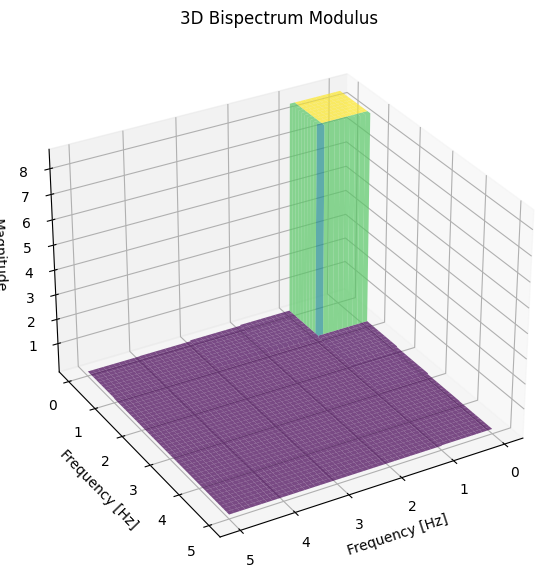

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# ... [Previous code for light curve generation, interpolation, etc.]

def bispectrum(y, max_freq=0.5, freq_bins=100):
    Y = fft(y)
    n = len(Y)
    bisp = np.zeros((freq_bins, freq_bins), dtype=complex)
    freq_values = np.linspace(0, max_freq, freq_bins)
    bin_width = n * max_freq / freq_bins

    for i, f1 in enumerate(freq_values):
        for j, f2 in enumerate(freq_values):
            index1 = int(f1 * bin_width)
            index2 = int(f2 * bin_width)
            bisp[i, j] = Y[index1] * Y[index2] * np.conjugate(Y[int((index1 + index2) % n)])

    return freq_values, bisp

freq_values, bisp = bispectrum(y_even, max_freq=5, freq_bins=1000)

# Ensure the magnitude values are within expected range
magnitude = np.abs(bisp)
print(f"Minimum magnitude: {magnitude.min()}")
print(f"Maximum magnitude: {magnitude.max()}")

# 3D Plotting of bispectrum modulus
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(freq_values, freq_values)
Z = magnitude

ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.7)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Frequency [Hz]')
ax.set_zlabel('Magnitude')
ax.set_title('3D Bispectrum Modulus')
ax.view_init(30, 60)  # Adjust view angle for


Random Walk & Non-linear Interactions: While the provided code is a simple random walk, the accumulation of random changes can introduce non-linearities in the time series. It's not directly a sinusoidal or periodic signal, but the accumulation of random values (even though they are linearly generated) can lead to higher-order statistical properties in the signal.

Bispectrum Sensitivity: The bispectrum is sensitive to non-linear interactions, even if they are subtle. Even though the signal's generation is relatively simple, the higher-order statistics, like the bispectrum, can capture even minute non-linear interactions.

Presence of a Peak: The distinct peak in the bispectrum might be surprising given the simple nature of the signal generation. However, it suggests that the random walk process, as simple as it is, has introduced certain phase relationships in the accumulated signal.

Caution on Over-interpretation: Given that we know the method of generation, it's important to be cautious and not to over-interpret the bispectrum results. The non-linear interaction observed might not be due to some inherent underlying physical processes, but more due to the accumulation of random increments.


 5. Multifractal Detrended Fluctuation Analysis (MFDFA)


Multifractal Detrended Fluctuation Analysis MFDFA is a model-independent method to uncover the self-similarity of a stochastic process or auto-regressive model. DFA was first developed by Peng et al. and later extended to study multifractality MFDFA by Kandelhardt et al.[ Please see this github](https://github.com/LRydin/MFDFA/tree/master)


Scaling Behavior and Hurst Exponent (H):

The plot suggests that the light curve exhibits a scaling behavior, as the Detrended Fluctuation Analysis (DFA) varies with the lag in a power-law fashion on a log-log scale.
The Hurst exponent (H) is given as 1.432. The Hurst exponent provides insights into the memory and persistence of the time series.

H=0.5: A purely random process (like white noise).

0.5<H<1: Positive correlation, persistence, or trending behavior in the time series.

H<0.5: Negative correlation or alternating behavior.

H>1: Not typical for standard time series and might indicate multifractality or other complex behaviors.
The value of  H=1.432 indicates that the light curve exhibits a strong persistent or trending behavior, which is greater than typical correlated time series. This suggests that large values in the light curve are likely to be followed by large values, and small values are more likely to be followed by small values.

DFA vs. Lag:

The DFA values increase with increasing lag on a logarithmic scale, indicating long-range correlations in the light curve data.
There is a noticeable bend or change in the slope around a lag of 10^2, indicating a possible crossover point. Crossover points can be indicative of different scaling behaviors at different time scales.


Multifractality:

The fact that the analysis was performed using MFDFA (as indicated by the plot title and
q=2) suggests the presence of multifractal behavior. However, to truly confirm and interpret multifractality, one would typically look at the spectrum of Hurst exponents obtained for a range of
q values, not just
q=2. The given plot only provides the DFA for
q=2, which corresponds to the standard (mono-fractal) DFA.


C:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Estimated H = 1.540


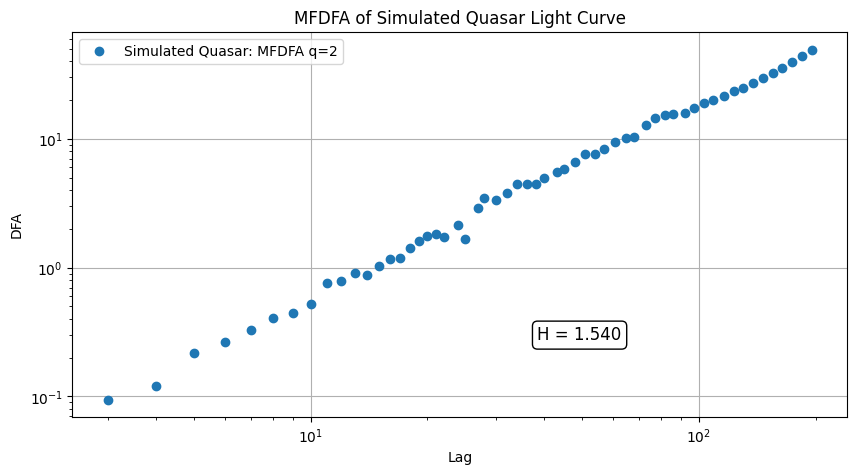

In [24]:
# Select a band of lags
lag = np.unique(np.logspace(0.5, 3, 100).astype(int))

# Power q
q = 2

# Polynomial fitting order
order = 1

# Compute MFDFA
lag, dfa = MFDFA(y, lag=lag, q=q, order=order)

# Plotting log-log MFDFA results
plt.figure(figsize=(10,5))
plt.loglog(lag, dfa, 'o', label='Simulated Quasar: MFDFA q=2')

# Fitting line to estimate Hurst index
slope, intercept = np.polyfit(np.log(lag)[4:20], np.log(dfa)[4:20], 1)
H_hat = slope[0]
print(f'Estimated H = {H_hat:.3f}')

# Annotating the Hurst index on the plot
plt.annotate(f'H = {H_hat:.3f}', xy=(0.6, 0.2), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", fc="w"))
plt.title('MFDFA of Simulated Quasar Light Curve')
plt.xlabel('Lag')
plt.ylabel('DFA')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
H_hat = slope[0]
print(f'Estimated H = {H_hat:.3f}')

Estimated H = 1.540


In [15]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = False

colours = ['#1b9e77','#d95f02','#7570b3']

1.0 3.25 4.825 6.175 7.525 9.775


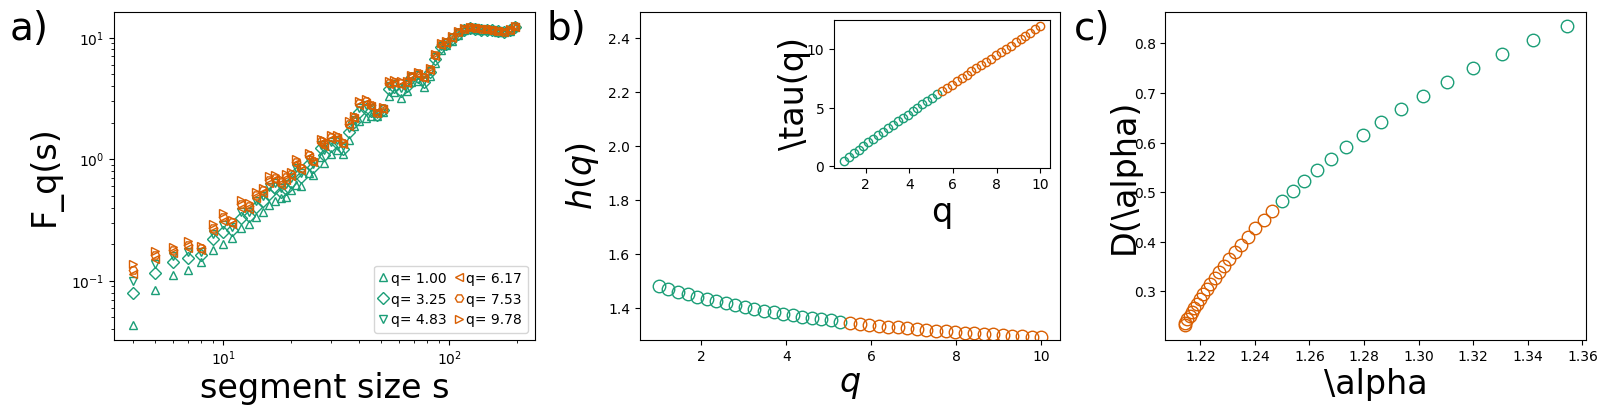

In [16]:
# %%
lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
q_list = np.linspace(1,10,41)
q_list = q_list[q_list!=0.0]
lag, dfa_sun =  MFDFA(y, lag, q=q_list, order=2)
print(q_list[0], q_list[10],q_list[17],q_list[23],q_list[29], q_list[39])
# %% ################################## FIG03 ##################################
fig, ax = plt.subplots(1,3, figsize=(16,4))

ax[0].loglog(lag[:], dfa_sun[:,[0]],  '^', markersize=6, markerfacecolor='none',
    color=colours[0], label=f'q= {q_list[0]:.2f}')
ax[0].loglog(lag[:], dfa_sun[:,[10]], 'D', markersize=6, markerfacecolor='none',
    color=colours[0], label=f'q= {q_list[10]:.2f}')
ax[0].loglog(lag[:], dfa_sun[:,[17]], 'v', markersize=6, markerfacecolor='none',
    color=colours[0], label=f'q= {q_list[17]:.2f}')
ax[0].loglog(lag[:], dfa_sun[:,[23]], '<', markersize=6, markerfacecolor='none',
    color=colours[1], label=f'q= {q_list[23]:.2f}')
ax[0].loglog(lag[:], dfa_sun[:,[29]], 'H', markersize=6, markerfacecolor='none',
    color=colours[1], label=f'q= {q_list[29]:.2f}')
ax[0].loglog(lag[:], dfa_sun[:,[39]], '>', markersize=6, markerfacecolor='none',
    color=colours[1], label=f'q= {q_list[39]:.2f}')

ax[0].set_ylabel(r'F_q(s)',labelpad=7,fontsize=24)
ax[0].set_xlabel(r'segment size s',labelpad=3,fontsize=24)

slopes_s1 = np.polynomial.polynomial.polyfit(np.log(lag)[20:55],np.log(dfa_sun)[20:55],1)[1]

ax[1].plot(q_list[:20], slopes_s1[:20],'o', markersize=9,
    markerfacecolor='none', color=colours[0])
ax[1].plot(q_list[20:], slopes_s1[20:],'o', markersize=9,
    markerfacecolor='none', color=colours[1])

ax[1].set_ylim([None,2.5])
ax[1].set_ylabel(r'$h(q)$',labelpad=5,fontsize=24)
ax[1].set_xlabel(r'$q$',labelpad=3,fontsize=24)

axi2 = fig.add_axes([0.52, 0.6, 0.135, .37])
axi2.plot(q_list[:20], q_list[:20]*slopes_s1[:20]-1,'o', markersize=6,
    color=colours[0], markerfacecolor='none')
axi2.plot(q_list[20:], q_list[20:]*slopes_s1[20:]-1,'o', markersize=6,
    color=colours[1], markerfacecolor='none')

axi2.set_xlabel(r'q',labelpad=3,fontsize=24)
axi2.set_ylabel(r'\tau(q)',labelpad=-3,fontsize=24)


t_sun = q_list * slopes_s1 - 1
hq_sun = np.gradient(t_sun) / np.gradient(q_list)
f_sun = q_list * hq_sun - t_sun

ax[2].plot(hq_sun[5:20], f_sun[5:20],'o', markersize=9,
    markerfacecolor='none', color=colours[0])
ax[2].plot(hq_sun[20:], f_sun[20:],'o', markersize=9,
    markerfacecolor='none', color=colours[1])

ax[2].set_xlabel(r'\alpha',labelpad=3,fontsize=24)
ax[2].set_ylabel(r'D(\alpha)',labelpad=-5,fontsize=24)

ax[0].legend(loc=4, handletextpad=.3, handlelength=.5, ncol=2,
    columnspacing=.65)

locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax[0].yaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax[0].yaxis.set_minor_locator(locmin)
ax[0].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.text(.005, .92, r'a)', fontsize=28)
fig.text(.34, .92, r'b)', fontsize=28)
fig.text(.67, .92, r'c)', fontsize=28)

fig.subplots_adjust(left=.07, bottom=.17, right=.99, top=.99, hspace=.06,
    wspace=.25)

This set of plots provides a multifractal analysis of the data, likely based on the Multifractal Detrended Fluctuation Analysis (MFDFA) approach. Each of the panels reveals different aspects of the data's multifractality. Let's analyze and interpret them:

a) Fluctuation Function F(q, s) vs. Segment Size s:

This plot depicts the fluctuation function F(q,s) against the segment size s for different values of q.
Different q values probe different statistical moments of the data. A wide range of slopes for different q values indicates multifractality.
The data seems to follow a power-law relationship across different segment sizes, indicating scaling behavior.The different slopes for different q values suggest that the data exhibits multifractal characteristics. If it were monofractal, all the lines would essentially overlap.

b) Generalized [Hurst](https://en.wikipedia.org/wiki/Hurst_exponent#:~:text=The%20Hurst%20exponent%20is%20referred,to%20cluster%20in%20a%20direction.) Exponent h(q) and τ(q) vs. q:

The left part of this panel shows the generalized Hurst exponent  h(q) as a function of q. The generalized Hurst exponent provides insights into the scaling behavior of different statistical moments of the data. A nonlinear behavior of h(q) with respect to q confirms the multifractal nature of the data. The inset shows τ(q) vs. q, which is another measure of multifractality. The linearity of this relationship is another typical characteristic of multifractal systems.

c) Singularity Spectrum D(α) vs. α:

This plot, known as the singularity spectrum, represents the fractal dimension D(α) of subsets of the data with a given singularity strength α. The width of the α spectrum provides information about the degree of multifractality: a wider spectrum indicates stronger multifractality. The fact that the spectrum is not reduced to a single point indicates multifractality in the data.


Summary and Further Analysis:

The provided plots confirm the multifractal nature of the data. The multifractality can arise from various factors, including long-range correlations, intermittency, or non-linear dynamics in the underlying system.

For further analysis:

It might be useful to compare the multifractal characteristics of the simulated data with real quasar light curves to see how closely the simulation matches real observations.
Determining the source of multifractality can provide insights into the underlying processes. For instance, is it driven by correlations, non-linear dynamics, or some other factor?
If you have other datasets, comparing their multifractal spectra can provide insights into similarities or differences in their underlying dynamics.
It might also be useful to apply other nonlinear time series analysis methods, like phase space reconstruction or recurrence analysis, to further probe the underlying dynamics of the data.






**TASK**

#### Maximum Likelihood Method

Compare the measured Power Spectrum (e.g. SF) with the Power Spectrum of simulated light curves.

● Simulate a library of light curves with different
model parameters (1000 per parameter set).

○ same observational gaps
○ same instrumental noise

● Calculate the Power Spectrum of each
simulated light curve.

○ affected in same way by gaps and noise

● Generate a PDF of the Power Spectrum for
each parameter set (e.g. slope and break).

● Find the best-fit PDF (maximum likelihood)



In [17]:
!pip install corner

In [18]:
!pip install emcee

In [19]:
y_obs=y

In [20]:
import emcee
from scipy.stats import gaussian_kde

# Simulate a library of light curves
def simulate_light_curves(t, param_grid, num_simulations=100):
    all_simulations = {}
    for params in param_grid:
        a, b = params
        simulations = [generate_light_curve(t, a, b) for _ in range(num_simulations)]
        all_simulations[(a, b)] = simulations
    return all_simulations


# Modifying the power spectrum calculation to handle zeros
def calculate_power_spectrum(t, y):
    frequency, power = LombScargle(t, y).autopower(minimum_frequency=0.01, maximum_frequency=1.0)
    # Adding a small value to avoid log(0)
    power = np.where(power == 0, 1e-10, power)
    return np.log10(frequency), np.log10(power)


# Calculate power spectra for each simulation
def calculate_all_power_spectra(t, simulations):
    power_spectra = {}
    for params, light_curves in simulations.items():
        power_spectra[params] = [calculate_power_spectrum(t, lc) for lc in light_curves]
    return power_spectra

# Run MCMC to find best-fit parameters (assuming you have observed data `y_obs`)
def run_mcmc(t, y_obs, param_grid):
    nwalkers, ndim = 32, len(param_grid[0])
    p0 = np.random.randn(nwalkers, ndim)

# Modifying the log_probability function
    def log_probability(params):
     a, b = params
     y_sim = generate_light_curve(t, a, b)
     _, power_sim = calculate_power_spectrum(t, y_sim)
     _, power_obs = calculate_power_spectrum(t, y_obs)
     chi2 = np.sum(((power_obs) - (power_sim))**2 / (power_sim))
    # Handling potential NaN or inf values
     if np.isnan(chi2) or np.isinf(chi2):
        return -np.inf
     return -0.5 * chi2

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

    sampler.run_mcmc(p0, 5000, progress=True);
    return sampler  # <-- Add this line
# Generate your parameter grid (change ranges accordingly)
param_grid = [(a, b) for a in np.linspace(0.08, 0.12, 50) for b in np.linspace(0.35, 0.55, 50)]

# Assuming you have time array `t` and observed data `y_obs`
#all_simulations = simulate_light_curves(t, param_grid)
#power_spectra = calculate_all_power_spectra(t, all_simulations)

sampler = run_mcmc(t, y_obs, param_grid)

You must install the tqdm library to use progress indicators with emcee
C:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\implementations\fast_impl.py:121: RuntimeWarning: overflow encountered in square
  YY = np.dot(w, y**2)
C:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\implementations\fast_impl.py:131: RuntimeWarning: overflow encountered in divide
  power = YC * YC / CC + YS * YS / SS
C:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\implementations\fast_impl.py:134: RuntimeWarning: invalid value encountered in divide
  power /= YY
C:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\implementations\fast_impl.py:131: RuntimeWarning: overflow encountered in multiply
  power = YC * YC / CC + YS * YS / SS
C:\Users\marko\A

You must install the tqdm library to use progress indicators with emcee


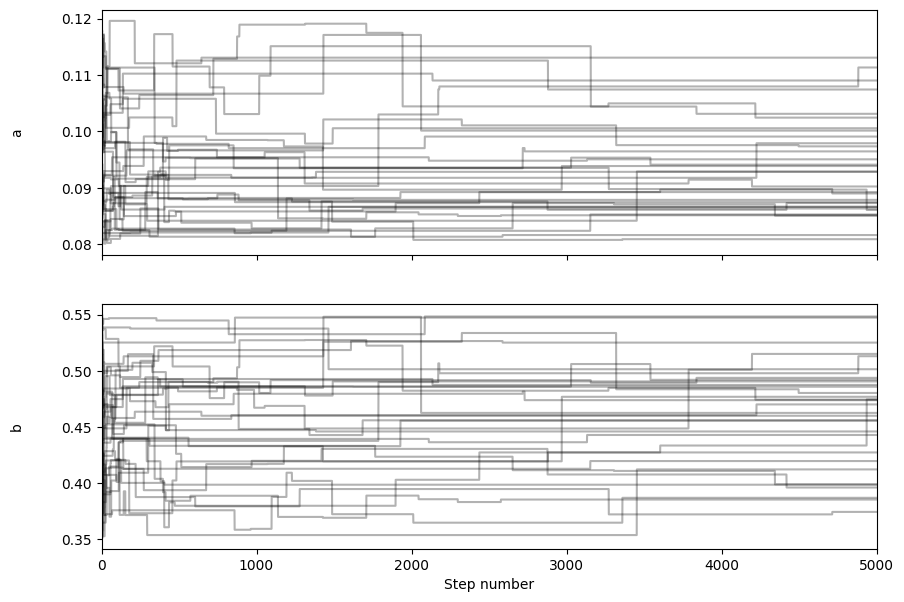

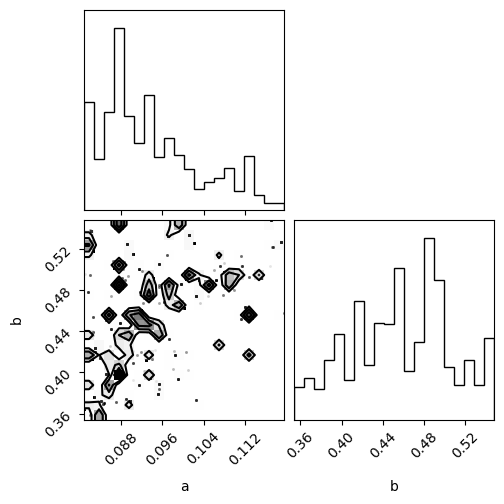

In [21]:
import emcee
from scipy.stats import gaussian_kde

# ... [rest of your code above the run_mcmc function]

def run_mcmc(t, y_obs, param_grid):
    nwalkers, ndim = 32, len(param_grid[0])

    # Initialize p0 closer to the expected values
    p0 = np.array([[
        np.random.uniform(0.08, 0.12),
        np.random.uniform(0.35, 0.55)] for _ in range(nwalkers)
    ])

    def log_probability(params):
        a, b = params

        # Introducing the prior here
        if not (0.08 <= a <= 0.12) or not (0.35 <= b <= 0.55):
            return -np.inf

        y_sim = generate_light_curve(t, a, b)
        _, power_sim = calculate_power_spectrum(t, y_sim)
        _, power_obs = calculate_power_spectrum(t, y_obs)
        chi2 = np.sum((power_obs - power_sim)**2 / power_sim)

        # Handling potential NaN or inf values
        if np.isnan(chi2) or np.isinf(chi2):
            return -np.inf
        return -0.5 * chi2

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
    sampler.run_mcmc(p0, 5000, progress=True);
    return sampler  # Return the sampler object


param_grid = [(a, b) for a in np.linspace(0.08, 0.12, 50) for b in np.linspace(0.35, 0.55, 50)]

# Assuming you have time array `t` and observed data `y_obs`
# all_simulations = simulate_light_curves(t, param_grid)
# power_spectra = calculate_all_power_spectra(t, all_simulations)

sampler = run_mcmc(t, y_obs, param_grid)

def plot_trace(sampler):
    # Get the chains from the sampler
    samples = sampler.get_chain()

    fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

    labels = ["a", "b"]
    for i in range(2):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("Step number")
    plt.show()

# Plotting the trace for the MCMC chains
plot_trace(sampler)

# If you want to plot a corner plot
import corner
samples_flat = sampler.get_chain(discard=100, thin=15, flat=True)
figure = corner.corner(samples_flat, labels=["a", "b"])
plt.show()

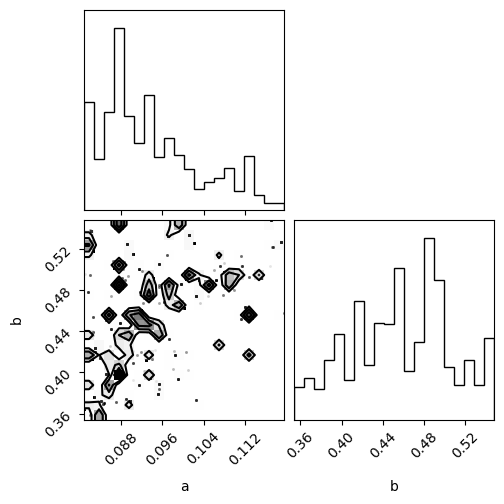

In [22]:
import corner
import matplotlib.pyplot as plt

# Extract the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)  # Adjust discard and thin based on the MCMC run

# Plot the corner plot
figure = corner.corner(samples, labels=["a", "b"])  # "a" and "b" are the parameters

plt.show()

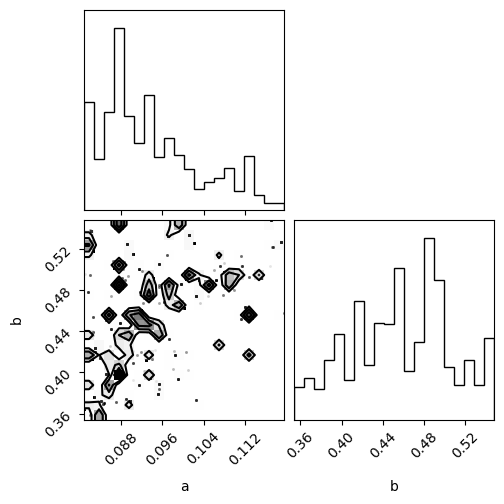

In [23]:
import corner
import matplotlib.pyplot as plt

# Extract the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)  # Adjust discard and thin based on the MCMC run

# Plot the corner plot
figure = corner.corner(samples, labels=["a", "b"])  # "a" and "b" are the parameters

plt.show()
